# 1. import needed package

In [5]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from dataset import *
from netlib import *
from backgrad_utils import *
import os
import shutil
from cifar10_utils import show_images, parse_log, show_log, update
import utils
from mxnet.gluon.data.dataset import ArrayDataset
import pandas as pd

ctx = mx.gpu(0)
arrayds_dir = '/home/hui/dataset/CIFAR10/arraydataset/'

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

# 2. data loader, data argument

In [6]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')

"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def load_all_data_label(pathes):
    all_data, all_label = None, None
    for path in pathes:
        data, label = nd.load(path)
        label = label.reshape((-1,)).astype('float32')
        if all_data is None:
            all_data, all_label = data, label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
    return all_data, all_label


def data_loader2(batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 2, 2], origin_shuffle=False):
    origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=transform[0])
    origin_data = gluon.data.DataLoader(origin_ds, batch_size[0], shuffle=origin_shuffle, last_batch='keep', num_workers=num_workers[0])
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=transform[1])
    train_data = gluon.data.DataLoader(train_ds, batch_size[1], shuffle=True, last_batch='keep', num_workers=num_workers[1])
    
    test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform[2])
    test_data = gluon.data.DataLoader(test_ds, batch_size[2], shuffle=False, last_batch='keep', num_workers=num_workers[2])
    return (origin_data, train_data, test_data), (origin_ds, train_ds, test_ds)

# 3 data aurgument: mixup
1. mixup define
2. mixup visualize

In [7]:
import numpy as np
def mixup(x1, y1, x2, y2, alpha, num_class):
    y1 = nd.one_hot(y1, num_class)
    y2 = nd.one_hot(y2, num_class)
    
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

# 3. data augment: back grad

## 3.1 define a simple back grad method

In [8]:
import utils
import os, shutil
%matplotlib inline

EPS = 1e-30

def show_data(data, clip=True):
    images = inv_normalize(data, clip=clip)
    show_images(images, clip=clip)
    
def get_soft_label(y, num_class, soft_label_th):
    y = y.reshape((-1,))
    ny = (y.one_hot(num_class) + soft_label_th / num_class)
    y = y.asnumpy()
    ny[range(y.shape[0]), y.astype('int32')] -= soft_label_th
    return nd.array(ny)
   
def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))
    
def statistic(diffs):
    t = np.mean(diffs), np.max(diffs), np.min(diffs), np.std(diffs)
    return t
    
def inv_normalize(data, mean=None, std=None, clip=True, asnumpy=True):
    if mean is None: mean=nd.array([0.4914, 0.4822, 0.4465])
    if std is None: std=nd.array([0.2023, 0.1994, 0.2010])
    if asnumpy: 
        data, mean, std = data.asnumpy(), mean.asnumpy(), std.asnumpy()
    images = data.transpose((0, 2, 3, 1))
    images = images * std + mean
    images = images.transpose((0, 3, 1, 2)) * 255
    if clip: 
        images = images.clip(0, 255)
    return images

mean=nd.array([0.4914, 0.4822, 0.4465])
std=nd.array([0.2023, 0.1994, 0.2010])
threshold = (nd.array([[0, 0, 0], [1, 1, 1]]) - mean) / std

class BackGradDataGenerator:
    """
        just a set of many static function
    """
    # 2. function to generate back_grad data
    
    @staticmethod
    def SGD(data, lr):
        # print nd.mean(data.grad).asscalar()
        data[:, :, :, :] = data - data.grad * lr
    
    @staticmethod
    def generate_backgrad_data(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=False, 
                               loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), bn_control=None, sgd=None, threshold=None):
        """
            data is better in cpu, if data in ctx(global var), the returned backgrad_data is shallow copy of data.
        """
        context = data.context
#         if str(context)[:3] != "cpu":
#             print "warring: data was not in CPU, the returned backgrad_data is shallow copy of data."
        if bn_control is not None:
            bn_control.store()
        if sgd is None:
            sgd = BackGradDataGenerator.SGD

        data, label = data.as_in_context(ctx), label.as_in_context(ctx)
        for iters in range(1, max_iters+1):
            with autograd.record():
                data.attach_grad()
                output = net(data)
                loss = -loss_f(output, label)
            loss.backward()
            mean_loss = nd.mean(loss).asscalar()     # reduce will make memory release

            if iter_log and iters % 50 == 0:
                show_data(data[:5], clip)
                #print data[0, 0, :2, :10]
                #print data.grad[0, 0, :2, :10]
            if iter_log and iters % 5 == 0:
                print 'iter:', iters, 'loss:', mean_loss

            sgd(data, lr)
        if threshold is not None:
            for i in range(3):
                data[:, i, :, :] = data[:, i, :, :].clip(threshold[0, i].asscalar(), threshold[1, i].asscalar())
        if bn_control is not None:
            bn_control.load()
            
        return data.as_in_context(context), (loss.as_in_context(context), mean_loss, )
    
    @staticmethod
    def MSE_constraint(mse, same_rate=False):
        def constraint(backgrad_data, data, diff, _loss, MSE, SNR):
            if same_rate:
                rate = nd.mean(nd.sqrt(mse / MSE))
                backgrad_data[:, :, :, :] = data + ((backgrad_data - data) * rate)
            else:
                backgrad_data[:, :, :, :] = data + ((backgrad_data - data).transpose((1, 2, 3, 0))
                                                * (nd.sqrt(mse / MSE))).transpose((3, 0, 1, 2))
        return constraint
    
    @staticmethod
    def generate_backgrad_data_constraint(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=False, 
                               loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), bn_control=None, post_deal=None, 
                                          sgd=None, threshold=None):
        backgrad_data, (_loss, _bloss, ) = BackGradDataGenerator.generate_backgrad_data(net, data.as_in_context(mx.cpu()), label, 
                                            max_iters, lr, iter_log, clip, loss_f, bn_control, sgd, threshold)
        
        if post_deal is not None:
            tmp = (backgrad_data - data) ** 2
            diff = nd.sqrt(nd.sum(tmp, axis=0, exclude=True))
            MSE = nd.mean(tmp, axis=0, exclude=True)
            Savg = nd.mean((data) ** 2, axis=0, exclude=True)
            # SNR = 10 * nd.log10(Savg / (MSE))
            SNR = 10 * nd.log10(Savg / (MSE + EPS))
            post_deal(backgrad_data, data, diff, _loss, MSE, SNR)
        return backgrad_data, (_loss, _bloss, ) 
            
    @staticmethod
    def generate_data_for_out(net, origin_data, max_iters=10, lr=0.1,
                            use_batch_mean_std=False, use_statistic=True, show_per_iters=None,
                            loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=None, begin_index=0, 
                            bn_control=None, post_deal=None, sgd=None, threshold=None):
        out_idx, iters = begin_index, 0
        diffs, losses, MSEs, SNRs, bloss = None, None, None, None, 0
        
        if bn_control is None:
            bn_backup = BNControl(net.net, use_batch_mean_std) # to avoid update moving_mean/std when generate image
            bn_backup.store()
        for data, label in origin_data:
            backgrad_data, (_loss, _bloss, ) = BackGradDataGenerator.generate_backgrad_data_constraint(
                net, data, label, max_iters=max_iters, lr=lr, iter_log=False, clip=False, loss_f=loss_f, 
                bn_control=bn_control, post_deal=post_deal, sgd=sgd, threshold=threshold)
            
            tmp = (backgrad_data - data) ** 2
            diff = nd.sqrt(nd.sum(tmp, axis=0, exclude=True))
            MSE = nd.mean(tmp, axis=0, exclude=True)
            Savg = nd.mean((data) ** 2, axis=0, exclude=True)
            # SNR = 10 * nd.log10(Savg / (MSE))
            SNR = 10 * nd.log10(Savg / (MSE + EPS))
            if sgd is not None or post_deal is not None: # new change get new loss
                _loss = loss_f(net(backgrad_data.as_in_context(ctx)), label.as_in_context(ctx))
                _bloss = nd.mean(_loss).asscalar()
            bloss += _bloss

            if diffs is None: 
                diffs, losses, MSEs, SNRs = diff, _loss, MSE, SNR
            else:
                diffs, losses = nd.concat(diffs, diff, dim=0), nd.concat(losses, _loss, dim=0)
                MSEs, SNRs = nd.concat(MSEs, MSE, dim=0), nd.concat(SNRs, SNR, dim=0)
                
            # must copy to cpu, or will make gpu memory leak(not release)
            backgrad_data = inv_normalize(backgrad_data, clip=False, asnumpy=False)
            out_data[out_idx:out_idx+data.shape[0], :, :, :] = backgrad_data.transpose((0, 2, 3, 1)).as_in_context(mx.cpu())
            out_idx += data.shape[0]
                    
            if show_per_iters is not None and iters % show_per_iters == 0:
                show_images(inv_normalize(data[np.array(range(0, 25, 5)) % data.shape[0]], clip=False), clip=False)
                show_images(backgrad_data[np.array(range(0, 25, 5)) % data.shape[0]].asnumpy(), clip=False)
            iters += 1
        if bn_control is None:
            bn_backup.load()
        
        diffs, losses, MSEs, SNRs = diffs.asnumpy(), losses.asnumpy(), MSEs.asnumpy(), SNRs.asnumpy()
        if use_statistic:
            return statistic(diffs), statistic(losses), statistic(MSEs), statistic(SNRs)
        else:
            return diffs, losses, MSEs, SNRs    
        
BGG = BackGradDataGenerator

load data
accuracy: 1.0


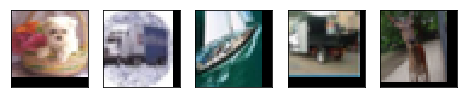

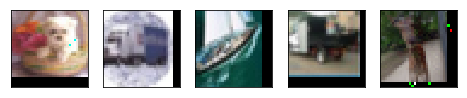

0.00137055 0.0155063 2.67227e-05 0.00267278


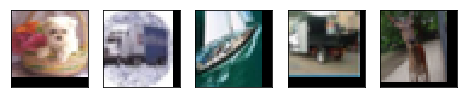

0.003 0.003 0.003 3.73279e-10


In [9]:
import random
try:
    origin_data_array
except BaseException:
    print "load data"
    origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])

def test(origin_data_array, origin_label_array, shuffle=True):
    indices = range(0, 50000)
    if shuffle: 
        random.shuffle(indices)
    indices = nd.array(indices[:256])
    origin_data_array, origin_label_array = origin_data_array.take(indices), origin_label_array.take(indices)
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=transform_train_DA1)#_transform_test)
    origin_data = gluon.data.DataLoader(origin_ds, 128, shuffle=False, num_workers=0)
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 128, shuffle=False, num_workers=2)
    
    net = ResNet(10)
    #net.initialize(ctx=ctx)
    #net.load_params('../../models/resnet18_me_backgrad_prob_online_iter10_lr01', ctx=ctx)
    net.load_params('../../models/resnet18_me_200e', ctx=ctx)
    print "accuracy:", utils.evaluate_accuracy(train_data, net, ctx)
    
    for data, label in origin_data:
        break
    show_data(data[:5], clip=False)
    
    bn_control = BNControl(net.net, True)
    constraint = None#BGG.MSE_constraint(0.003)
    backgrad_data, _ = BGG.generate_backgrad_data(net,
                data, label, max_iters=10, lr=0.1, bn_control=bn_control)
    tmp = (backgrad_data - data) ** 2
    diff = nd.sqrt(nd.sum(tmp, axis=0, exclude=True))
    MSE = nd.mean(tmp, axis=0, exclude=True).asnumpy()
    show_data(backgrad_data[:5], clip=False)
    print np.mean(MSE), np.max(MSE), np.min(MSE), np.std(MSE)
    
    constraint = BGG.MSE_constraint(0.003)
    backgrad_data, _ = BGG.generate_backgrad_data_constraint(net,
                data, label, max_iters=10, lr=0.1, bn_control=bn_control, post_deal=constraint)
    tmp = (backgrad_data - data) ** 2
    diff = nd.sqrt(nd.sum(tmp, axis=0, exclude=True))
    MSE = nd.mean(tmp, axis=0, exclude=True).asnumpy()
    show_data(data[:5], clip=False)
    print np.mean(MSE), np.max(MSE), np.min(MSE), np.std(MSE)
    
    
test(origin_data_array, origin_label_array, True)

# 4. analysis

## 4.1 only use 128 images to simple test
loss != -acc != -MSE

In [12]:
import random

try:
    origin_data_array
except:
    origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])

def test(generate_net, test_net, origin_data_array, origin_label_array, 
         shuffle=True, transform=_transform_test, constraint=None, threshold=None):
    indices = range(0, 50000); 
    if shuffle: 
        random.shuffle(indices); 
    indices = nd.array(indices[:128])
    origin_data_array, origin_label_array = origin_data_array.take(indices), origin_label_array.take(indices)
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=transform)#_transform_test)
    origin_data = gluon.data.DataLoader(origin_ds, 128, shuffle=False, num_workers=0)
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=transform)
    train_data = gluon.data.DataLoader(train_ds, 128, shuffle=True, num_workers=2)
    
    net = ResNet(10)
    if generate_net == "random init":
        net.initialize(ctx=ctx)
    else:
        net.load_params("../../models/" + generate_net, ctx=ctx)
    utils.evaluate_accuracy(train_data, net, ctx)
    
    xs = BGG.generate_data_for_out(net, origin_data, max_iters=10, lr=0.1,use_batch_mean_std=True, use_statistic=True, show_per_iters=None,
                                loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=train_ds._data[0][1], begin_index=0,
                                  post_deal=constraint, threshold=threshold)
    
    net.load_params("../../models/" + test_net, ctx=ctx)
    acc = utils.evaluate_accuracy(train_data, net, ctx)
    return xs, acc
 
constraint = BGG.MSE_constraint(0.003)
nets = ['random init', 'resnet18_me_200e', 'resnet18_me_backgrad_prob_online_iter10_lr01',
       'train8_resnet18_r1_i10_lr01_bT', 'train8_resnet18_r1_i10_lr01_bT_prob']

In [22]:
def ex_test(constraint, shuffle, transform, threshold):
    global acc_df, xs_df, index
    xs, acc = {}, {}
    for tn in nets[1:]:
        k_tn = tn.replace('_', ' ')
        xs[k_tn], acc[k_tn] = {}, {}
        for gn in nets:
            k_gn = gn.replace('_', ' ')
            xs[k_tn][k_gn], acc[k_tn][k_gn] = test(gn, tn, origin_data_array, origin_label_array,
                                                   shuffle, transform, constraint, threshold)
    acc_df.append(pd.DataFrame(data=acc))
    xs_df.append(pd.DataFrame(data=xs))
    
acc_df, xs_df = [], []
# ex_test(None, shuffle=True, transform=_transform_test, threshold=None)
# ex_test(None, shuffle=False, transform=_transform_test, threshold=threshold)
ex_test(None, shuffle=False, transform=transform_train_DA1, threshold=None)
ex_test(None, shuffle=False, transform=transform_train_DA1, threshold=threshold)

v_idx = {'diff': 0, 'loss': 1, 'MSE': 2, 'SNR': 3}

In [23]:
def get_xs(id1, var, id2):
    return pd.DataFrame([[v[v_idx[var]][id2] for v in line] for line in xs_df[id1].values]
             , index=[n.replace("_", ' ') for n in nets])

## 4.1

### 4.1.1 simple analysis

In [24]:
xs, acc = {}, {}
for tn in nets[1:]:
    k_tn = tn.replace('_', ' ')
    xs[k_tn], acc[k_tn] = {}, {}
    for gn in nets:
        k_gn = gn.replace('_', ' ')
        xs[k_tn][k_gn], acc[k_tn][k_gn] = test(gn, tn, origin_data_array, origin_label_array,
                            shuffle=False, transform=transform_train_DA1, constraint=None)
acc = pd.DataFrame(acc)
xs = pd.DataFrame(xs)

In [25]:
-pd.DataFrame([[v[v_idx['loss']][0] for v in line] for line in xs.values]
             , index=[n.replace("_", ' ') for n in nets])

,0,1,2,3
random init,2.379002,2.583985,2.065800,2.300379
resnet18 me 200e,19.586452,19.761568,19.712673,19.616890
resnet18 me backgrad prob online iter10 lr01,8.815062,8.786309,8.635487,8.645218
train8 resnet18 r1 i10 lr01 bT,12.925099,12.999937,12.919186,12.990898
train8 resnet18 r1 i10 lr01 bT prob,8.972747,8.865687,8.971344,8.765001


In [26]:
(1-acc.T) * 100 * 2 # train_data contain origin data

,random init,resnet18 me 200e,resnet18 me backgrad prob online iter10 lr01,train8 resnet18 r1 i10 lr01 bT,train8 resnet18 r1 i10 lr01 bT prob
resnet18 me 200e,0.00000,66.40625,6.25000,7.81250,2.34375
resnet18 me backgrad prob online iter10 lr01,0.00000,0.78125,4.68750,1.56250,1.56250
train8 resnet18 r1 i10 lr01 bT,0.78125,4.68750,5.46875,5.46875,5.46875
train8 resnet18 r1 i10 lr01 bT prob,0.00000,0.00000,2.34375,0.78125,0.78125


### 4.1.2 color clip: alomost make no diff.

In [27]:
get_xs(0, 'loss', 0)  # ex_test(None, shuffle=False, transform=transform_train_DA1, threshold=None)

,0,1,2,3
random init,-2.116816,-3.039940,-3.013283,-2.510832
resnet18 me 200e,-19.930014,-19.740627,-19.642788,-19.663712
resnet18 me backgrad prob online iter10 lr01,-8.703478,-8.620981,-8.673812,-8.608555
train8 resnet18 r1 i10 lr01 bT,-12.880213,-12.946293,-12.764915,-12.740609
train8 resnet18 r1 i10 lr01 bT prob,-8.838246,-9.086199,-9.144640,-8.991330


In [28]:
get_xs(1, 'loss', 0)  # ex_test(None, shuffle=False, transform=transform_train_DA1, threshold=threshold)

,0,1,2,3
random init,-3.662844,-2.566636,-1.936265,-2.423729
resnet18 me 200e,-19.586395,-19.793713,-19.707544,-19.810726
resnet18 me backgrad prob online iter10 lr01,-8.752985,-8.697500,-8.827636,-8.817623
train8 resnet18 r1 i10 lr01 bT,-12.843822,-12.896749,-12.935543,-12.780443
train8 resnet18 r1 i10 lr01 bT prob,-8.899344,-8.849463,-9.008923,-9.024295


In [29]:
(1-acc_df[0].T) * 100 * 2 # ex_test(None, shuffle=False, transform=transform_train_DA1, threshold=None)

,random init,resnet18 me 200e,resnet18 me backgrad prob online iter10 lr01,train8 resnet18 r1 i10 lr01 bT,train8 resnet18 r1 i10 lr01 bT prob
resnet18 me 200e,0.78125,65.62500,5.46875,8.59375,3.1250
resnet18 me backgrad prob online iter10 lr01,0.00000,1.56250,4.68750,3.90625,1.5625
train8 resnet18 r1 i10 lr01 bT,3.12500,3.12500,3.12500,10.15625,7.8125
train8 resnet18 r1 i10 lr01 bT prob,0.00000,0.78125,1.56250,1.56250,3.1250


In [30]:
(1-acc_df[1].T) * 100 * 2# ex_test(None, shuffle=False, transform=transform_train_DA1, threshold=threshold)

,random init,resnet18 me 200e,resnet18 me backgrad prob online iter10 lr01,train8 resnet18 r1 i10 lr01 bT,train8 resnet18 r1 i10 lr01 bT prob
resnet18 me 200e,2.34375,61.71875,6.25000,10.15625,6.25000
resnet18 me backgrad prob online iter10 lr01,0.00000,0.78125,1.56250,0.78125,1.56250
train8 resnet18 r1 i10 lr01 bT,1.56250,3.12500,7.03125,14.06250,6.25000
train8 resnet18 r1 i10 lr01 bT prob,1.56250,0.78125,2.34375,1.56250,2.34375
